<a href="https://colab.research.google.com/github/thispath98/NLP/blob/main/BERT/BERT_CoLA_of_GLUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERT: Fine-Tuning
===
# Fine-Tuning
* text classifier를 위해 `BERT`를 사용한다.
* `pre-trained BERT model`에 `untrained layer of neurons`를 마지막에 더할 것이다.
* `classification task`에 이 새로운 모델을 학습시킨다.

# Setup

In [ ]:
# 학습을 위해 Colab GPU를 사용한다.
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')

    print('There are %d GPU(s) available.'% torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
# Hugging Face Library 설치
!pip install transformers

# CoLA Dataset 가져오기
* 단일 문장 분류를 위해 GLUE-CoLA를 사용한다.
> ## GLUE-CoLA란?
> * 문장이 문법적으로 맞는지 틀린지를 라벨링한 문장들의 집합.


In [ ]:
# Colab instance's file system에 데이터셋을 다운로드하기 위해 wget 패키지 설치
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=5bf534b17edae62056a072ac834c136e7ae9bbc7c6940b2bc9f872575f1df44d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


CoLA Dataset은 여기에 있다
> https://nyu-mll.github.io/CoLA/

In [ ]:
import wget
import os

print('Downloading dataset...')

# The URL for the datset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we havent's already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [ ]:
# Datast 압출 풀기(만약 아직 압축풀기 안했다면...)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


* 다운로드된 데이터 파일을 확인해보면, `tokenized`와 `raw` 버전이 있다.
* 우리는 사전에 토큰화된(pre-tokenized) 버전을 사용할 수 없다. 왜냐하면 pre-trained BERT 모델에 적용하기 위해서는 **우리는 그 모델이 제공하는 tokenizer를 사용해야 한다.**
> * The model has a specific, fixed vocabulary.
> * The BERT tokenizer has a particular way of handling out-of-vocabulary words.

In [ ]:
import pandas as pd

df = pd.read_csv('/content/cola_public/raw/in_domain_train.tsv', delimiter='\t', header=None,
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('Number of training sentences: {:,}\n'.format(df.shape[0]))

df.sample(5)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
546,bc01,1,NaN,The branches knocked against the wall.
5344,b_73,1,NaN,Mary is taller than six feet.
852,bc01,0,*,"Mary came to read Fred's story, and I also cam..."
1151,r-67,0,?*,We elected the man who he had brought with him...
3388,l-93,1,NaN,He skated Penny around the rink.


* 총 8551개의 문장이 있다.
* 우리는 여기서 `label`, `sentences` 칼럼을 사용할 것이다.
* 0: unacceptable, 1: acceptable

In [ ]:
df.loc[df.label==0].sample(5)[['sentence', 'label']]

,sentence,label
4286,That he is clever is eager to be obvious.,0
2167,The cat touched.,0
1789,This rock is too heavy for me to begin to deci...,0
4147,He are the only person that I can rely on.,0
5513,That's a kindest answer that I ever heard.,0


In [ ]:
# numpy ndarrays 형태로 sentences와 labels 값 추출하기
sentences = df.sentence.values
labels = df.label.values

# 토큰화 & Input Formatting
* 여기서 우리는 우리의 데이터셋을 BERT가 학습할 수 있는 형태로 변환한다.
* BERT에 학습시키기 위해, 토큰화가 되어야한다.
* 이 토큰들은 반드시 **tokenizer vocabulary 안의 index에 매핑되어야 한다.**

## Masked Language Modeling(MLM)이란?
마스킨된 언어모델로, 입력으로 사용하는 문장의 토큰 중 15%의 확률로 선택된 토큰을 [MASK] 토큰으로 변환시키고, 언어 모델을 변환시키기 전 [MASK] 토큰을 예측하는 언어 모델.    

![](https://media.vlpt.us/images/nawnoes/post/2fff97ac-da64-46ce-997f-17b8af07f6b5/image.png)

## bert-base-uncased
* MLM을 사용하여 영어에 대해 pre-trained한 모델.
* `uncased`란? english와 English에 차이를 두지 않음.


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# 하나의 문장에 대해 tokenizer를 적용해서 결과를 확인해보자.
print('원래 문장: ', sentences[0])
print('토큰화된 문장: ', tokenizer.tokenize(sentences[0]))
# 토큰 인덱스로 매핑된 sentence 출력
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

원래 문장:  Our friends won't buy this analysis, let alone the next one we propose.
토큰화된 문장:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


실제로 우리가 우리의 모든 문장들을 변환할 때, `tokenize`와 `convert_tokens_to_ids`를 따로따로 호출하기보다, 두 단계를 다루기 위해 `tokenize.encode` 함수를 사용할 것이다.

## Required Formatting
1. 각각의 문장의 맨 앞과 끝에 `special token`을 추가한다.
2. 모든 문장을 정해진 길이로 `Pad & truncate`한다.
3. `attention mask`를 사용하여 진짜 토큰과 padding 토큰을 구별한다.

> ## Special Tokens
> * `[SEP]`: 문장의 맨 끝
>* `[CLS]`: 문장의 맨 앞. BERT는 12개의 Transformer layers를 포함한다. 각각의 transformer는 토큰 임베딩 list를 가져와서 출력에 동일한 수의 임베딩을 생성한다.
![](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)    

> * 12번째 마지막 transformer에서 오직 첫번째 임베딩([CLS]에 상응한다.)이 classifier로 사용한다.
> * [CLS]에 상응하는 마지막 hidden state는 classification task를 위한 전체 sequence representation으로써 사용된다.
> * BERT는 classificationd를 위해 오직 이 [CLS] 토큰만을 사용한다.

## Sentence Lenght & Attention Mask
* 우리 데이터셋 안에 있는 문장들은 다양한 문장 길이를 가진다. BERT는 이것들을 어떻게 다룰까?
* BERT는 두 가지 제약이 있다.
> 1. 모든 문장들은 고정된 길이의 단일 문장으로 padding/truncated 되어야 한다.
> 2. 문장의 최대 길이는 512 tokens이다.
* Padding은 special token [PAD]로 수행된다. 이 토큰은 BERT vocabulary에서 index 0에 위치한다.
* 아래 그림은 MAX_LEN을 넘은 padding을 나타낸다.    
![](http://www.mccormickml.com/assets/BERT/padding_and_mask.png)


* Attention Mask는 0과 1로 이루어진 심플한 array이다.
* Attention Mask는 어떤 토큰들이 padding이고 어떤 토큰들이 아닌지를 나타낸다.
* 이 attention mask는 BERT의 Self-Attention 메커니즘에 이러한 PAD 토큰을 문장의 해석에 적용하지 말라고 지시한다.

In [ ]:
# Tokenize Dataset
# 우리의 text를 인코딩하기 전에, padding과 truncating을 위한 maximum sentence length를 결정해야 한다.
# 이 코드는 데이터셋의 하나의 토큰화를 수행한다.
# 그럼으로써 maximum sentence length를 측정한다.
max_len = 0
for sent in sentences:
    # text 토큰화 -> add [CLS], [SEP]
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # update the maximum sentence length
    max_len = max(max_len, len(input_ids))

print('Max sentences length: ', max_len)

Max sentences length:  47


우리는 여기서 최대 길이를 64라고 정한다.

이제 우리는 진짜 토큰화를 진행할 준비가 되었다.    
`tokenizer.encode_plus` 함수는 여러 과정을 합친다.
1. 문장을 토큰으로 나눈다.
2. [CLS]와 [SEP]을 추가한다.
3. token들과 ID들을 매핑시킨다.
4. 모든 문장을 일정한 길이로 Pad or Truncate 한다.
5. 진짜 토큰들과 [PAD] 토큰들을 명시적으로 구별하는 attention mask를 생성한다.    

1~4번은 `tokenizer.encode`에 있다. 하지만 우리는 `tokenizer.encode_plus`를 사용하여 attention mask까지 수행한다.

In [ ]:
# 모든 문장들을 토큰화하고, 토큰들과 단어 ID들을 매핑시킨다.
input_ids = []
attention_masks = []

# For every sentences...
for sent in sentences:
    # 'encode_plus'가 하는 일!
    # 1. 문장 토큰화
    # 2. [CLS], [SEP] 추가
    # 3. mapping (tokens, IDs)
    # 4. max_length에 맞춰 문장 Padding/Truncating
    # 5. [PAD] 토큰을 위한 attention mask 생성
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens=True,
                        max_length=64,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt'     # return pytorch tensors
                    )
    # Add the encoded sentence to the list
    input_ids.append(encoded_dict['input_ids'])

    # attention mask ( defferentiate padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# sentence[0] 출력.
print('원래 문장: ', sentences[0])
print('Token IDs: ', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


원래 문장:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs:  tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


## Training & Validation Split
9:1 비율로 train/test set 나누기

In [ ]:
from torch.utils.data import TensorDataset, random_split

# training input을 TensorDataset으로 결합시킨다.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-val split

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# 랜덤으로 데이터셋을 나눈다.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


우리는 우리의 dataset이 torch Dataset class를 사용하기 위해 iterator를 만들어준다. 이것은 학습하는 동안 memory를 절약해주는데, loop와 달리 전체 데이터셋이 메모리로 로드되는 것을 필요로 하지 않기 때문이다.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# DataLoader: training batch size를 알아야한다.
# 특정한 task에 대한 fine-tuning BERT를 위해 저자는 batch size를 16 또는 32를 권장한다.
batch_size = 32

# 우리의 train/val set을 위한 DataLoader를 생성한다.
# 우리는 랜덤 순서로 training samples를 취할 것이다.
train_dataloader = DataLoader(
                    train_dataset,
                    sampler=RandomSampler(train_dataset),
                    batch_size=batch_size
                )

# Validation은 순서가 중요하지 않기 때문에 그냥 순서대로 읽는다.
validation_dataloader = DataLoader(
                            val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=batch_size
                        )

여기까지 우리 input data가 적절하게 포멧팅되었다. 이제 BERT model를 fine-tuning 해보자.

# Train Our Classification Model
> ## BertForSequenceClassification
>* 주어진 task를 수행하기 위해 우리는 먼저 pre-trained BERT model를 수정하고 싶다.
>* classification을 위한 output
>* end-to-end로 우리 데이터셋에 대하여 모델을 학습시키는 것이 우리 task에 더 적절하다.

* HuggingFace는 다양한 nlp task를 위한 인터페이스들을 제공한다. 
* 비록 이 인터페이스들이 trained BERT model 맨 위에 지어졌더라도, 각각은 서로 다른 top layers와 output types를 갖는다. (특정한 nlp task를 수용하기 위해 만들어졌음)

> ## Fine-Tuning을 위해 제공된 class들
>1. `BertModel`
>2. `BertForPreTraining`
>3. `BertForMaskedLM`
>4. `BertForNextSentencePrediction`
>5. `BertForSequenceClassification`
>6. `BertForTokenClassification`
>7. `BerForQuestionAnswering`

* 우리가 사용할 `BertForSequenceClassification`은 단일 선형 레이어를 맨 위에 추가했다. (분류를 위해)
* 우리는 문장 분류를 위해 이것을 사용할 것이다.
* 우리 dataset을 투입하면, 전체 pre-trained BERT model과 추가된 untrained classification layer는 우리의 특정한 task에 대해 학습된다.

* 이제 BERT를 로딩해보자! 조금 서로 다른 pre-trained BERT model들을 이용할 수 있다. 
* `bert-based-uncased`는 오직 lowercase letter(uncased)만을 가진다. 그리고 (base vs large)의 두 가지 작은 버전을 가진다.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# BertForSequenceClassificatoin: pretrained BERT model + untrained linear classification layer on top
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2, # output label 수. 우리는 이진 분류를 할 것이다! 증가시킬수도 있다.
    output_attentions=False, # 모델이 attention weights를 반환하는지 아닌지
    output_hidden_states=False, # 모델이 모든 hidden-states를 반환하는지 아닌지
)

# 파이토치에게 이 모델을 GPU에서 돌리라고 말한다.
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

이번에는 아래 가중치들에 대한 이름과 차원을 출력한다.
1. The embedding layer
2. The first of the twelve transformers
3. The output layer

In [ ]:
# 모든 모델 파라미터들을 튜플 리스트로 가져온다.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## Optimizer & Learning Rate Scheduler
이제 우리 모델이 로드되었다. 이제 우리는 저장된 모델로부터 학습용 하이퍼 파라미터를 확보해야한다.    

fine-tuning을 위해 저자는 아래 값들 중 하나를 선택하는 것을 권장한다.
>* **Bath size:** 16, 32
>* **Learning rate(Adam):** 5e-5, 3e-5, 2e-5
>* **Number of epochs:** 2, 3, 4    

우리는 여기서,
>* **Batch size:** 32(데이터로더 생성할 때 설정)
>* **Learning rate:** 2e-5
>* **Epochs:** 4

In [ ]:
# AdamW는 huggingface library의 클래스
optimizer = AdamW(model.parameters(),
                  lr=2e-5,      # args.learning_rate. default: 5e-4
                  eps=1e-8)     # args.adam_epsilon. default: 1e-8

In [ ]:
from transformers import get_linear_schedule_with_warmup

# training epochs 수. BERT 저자는 2 or 4를 권장.
epochs = 4

# total number of training steps = [number of batches] * [number of epochs]
# 이거는 트레이닝 샘플들의 수와 같지 않다.
total_steps = len(train_dataloader) * epochs

# learning rate scheduler 생성
# BERT 미세 조정을 위한 스케줄러
# 초기 lr에서부터 0까지 선형적으로 감소.
# 웜업 기간 이후에 0에서부터 lr까지 선형적으로 증가.
# optimizer
# num_warmup_steps: The number of steps for the warmup phase
# num_training_steps: The total number of training steps
# last_epoch: The index of the last epoch when resuming training
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

## Training Loop
아래는 training loop다. 루프에서 각 pass동안 training phase와 validation phase를 갖는다.

>## Training:
>* data inputs과 labels을 unpack
>* 이전 패스에서 계산된 gradients 초기화
    * 파이토치에서 gradient는 명시적으로 초기화해주지 않으면 누적된다.
>* Forward pass(feed input data through the network)
>* Backward pass(backpropagation)
>* Netword에 optimizer.step()으로 파라미터를 업데이터하라고 알린다.
>* 진행 상황을 모니터링하기 위한 변수 추적



>## Evaluation:
>* data inputs과 labels unpack
>* 가속화를 위한 GPU에 데이터 로드
>* Forward pass (feed input data through the netword)
>* validation data를 위한 손실 계산과 진행상황을 모니터링하기 위한 변수를 추적한다.

In [ ]:
# 정확도를 계산하기 위한 helper function 정의
import numpy as np

# 예측값과 label에 대한 정확도를 계산하는 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return np.sum(pred_flat==labels_flat) / len(labels_flat)

In [ ]:
# elapsed times를 hh:mm:ss로 포멧팅하기 위한 함수
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

이제 학습 시작!

In [ ]:
import random
import numpy as named_parameters

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

total_t0 = time.time()

# For each epoch...
for epoch_i in range(epochs):
    print("")
    print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
    print("Training...")

    # training epoch가 얼마나 걸렸는지 측정
    t0 = time.time()

    # 이번 epoch에 대한 total loss reset
    total_train_loss = 0

  
    # model을 training mode로 바꾼다. 
    # 이것은 그냥 '모드'를 바꾸는 것 뿐이다. 학습을 '수행'하는 것이 아님!
    model.train()

    # For each batch of training data...

    # add! 오류 테스트를 위한 변수
    
    #i = 0

    for step, batch in enumerate(train_dataloader):
        #i+=1
        #if i == 5: break
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('   Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step,
                                                                         len(train_dataloader),
                                                                         elapsed))
            
            # Unpack this training batch from our dataloader. 
            # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 항상 이전에 계산된 gradient를 backward pass 전에 초기화해준다.
        # 파이토치는 이 수행을 자동으로 하지 않는다. 
        # 왜냐하면 RNN을 학습시키는 동안 gradient를 축적시키는 것은 편리하기 때문이다.
        model.zero_grad()

        # forward pass 수행. (이 training batch에 대한 모델 평가)
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output.loss
        logits = output.logits
          
        # 모든 batch에 거쳐 training loss 누적시킴. 
        # 따라서 우리는 마지막에 평균 loss를 구할 수 있음.
        # loss는 단일 값을 포함하는 Tensor다.
        # item() 함수는 텐서로부터 파이썬 값을 반환
        total_train_loss += loss.item()

        # gradient 계산을 위해 역전파 수행
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # exploding gradients 문제를 막아줌.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
        # 파라미터 업데이트
        # 계산된 gradient를 사용하여 take step
        # optimizer는 update rule를 지시한다.
        optimizer.step()

        # learning rate update
        scheduler.step()

    # 모든 배치에 걸친 평균 loss 구하기
    avg_train_loss = total_train_loss / len(train_dataloader)

    # 에포크 걸린 시간 측정
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # 각 training epoch가 완료된 후, 우리 validation set에 대한 우리 performance 측정

    print("")
    print("Running Validation...")

    t0 = time.time()

    # 모델을 evaluation mode로 변경!
    # dropout layers는 평가 동안 다르게 행동한다.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            # Forward pass, logit predictions 계산
            output = model(b_input_ids,
                            token_type_ids = None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            loss = output.loss
            logits = output.logits
            
        total_eval_loss += loss.item()

        # logits과 labels를 CPU로 옮김
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # 이 validation run에서 최종 정확도 알림
    avg_val_accuracy = total_eval_loss / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======= Epoch 1 / 4 =======
Training...
   Batch    40  of    241.    Elapsed: 0:00:28.
   Batch    80  of    241.    Elapsed: 0:00:56.
   Batch   120  of    241.    Elapsed: 0:01:23.
   Batch   160  of    241.    Elapsed: 0:01:51.
   Batch   200  of    241.    Elapsed: 0:02:19.
   Batch   240  of    241.    Elapsed: 0:02:47.

  Average training loss: 0.49
  Training epcoh took: 0:02:47

Running Validation...
  Accuracy: 0.40
  Validation Loss: 0.40
  Validation took: 0:00:06

======= Epoch 2 / 4 =======
Training...
   Batch    40  of    241.    Elapsed: 0:00:28.
   Batch    80  of    241.    Elapsed: 0:00:56.
   Batch   120  of    241.    Elapsed: 0:01:23.
   Batch   160  of    241.    Elapsed: 0:01:51.
   Batch   200  of    241.    Elapsed: 0:02:19.
   Batch   240  of    241.    Elapsed: 0:02:47.

  Average training loss: 0.30
  Training epcoh took: 0:02:47

Running Validation...
  Accuracy: 0.43
  Validation Loss: 0.43
  Validation took: 0:00:06

======= Epoch 3 / 4 =======
Trainin

In [ ]:
# Training process summary
import pandas as pd

pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.49,0.40,0.40,0:02:47,0:00:06
2,0.30,0.43,0.43,0:02:47,0:00:06
3,0.20,0.50,0.50,0:02:47,0:00:06
4,0.15,0.56,0.56,0:02:47,0:00:06


* 만약 training loss가 감소하는 반면 validation loss가 증가한다면 이 모델은 오버피팅이 일어나고 있다는 것을 의미한다.

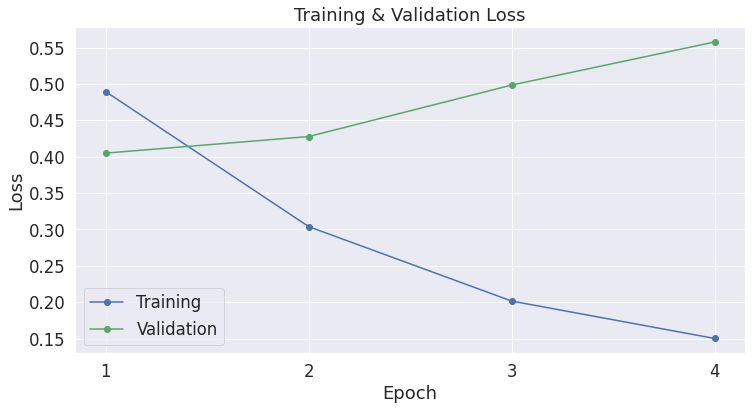

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12, 6)

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

plt.title("Training & Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Performance on Test Set


In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Evaluate on Test set
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


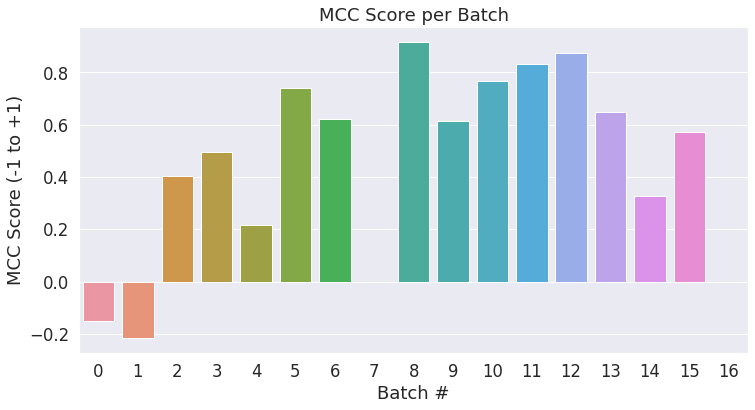

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.529
